In [1]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List

import sys


sys.path.append('./datasets/')

from datasets.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    


In [2]:
print(torch.__version__)

2.0.1+cu117


In [3]:
train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 62
epoch_total = 500
pickle_name = "femnist-epoch-"+str(epoch_total)

In [4]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [5]:



transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [6]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [7]:
def get_femnist_shakespeare_dataset(**args):
    if args['dataset'] == 'femnist' or args['dataset'] == 'shakespeare':
        trainloader, testloader = get_LEAF_dataloader(dataset=args['dataset'],
                                                      client_id=args['rank'])
    else:
        raise ValueError("Invalid dataset:", args['dataset'])
    return trainloader, testloader
    # PickleDataset('femnist')
    

In [8]:

train_loaders = []
test_loaders = []


for i in range(num_nodes):
    args = {'dataset': 'femnist', 'rank': i}
    trainloader, testloader = get_femnist_shakespeare_dataset(**args)
    train_loaders.append(trainloader)
    test_loaders.append(testloader)

#loader = zip(train_loaders, test_loaders)



In [9]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x000001C285268BB0>, <torch.utils.data.dataloader.DataLoader object at 0x000001C29C1CE080>, <torch.utils.data.dataloader.DataLoader object at 0x000001C29C1CD870>, <torch.utils.data.dataloader.DataLoader object at 0x000001C29C1CE380>, <torch.utils.data.dataloader.DataLoader object at 0x000001C29C1CEE30>]
35


In [10]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

ypred_test = []
ylabels_test = []

In [11]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 62)
        ).to(device)

        
        # only_digits=False
        # self.network = nn.Sequential(
        # nn.Conv2d(1, 32, kernel_size=3),
        # nn.MaxPool2d(2, stride=2),
        # nn.Conv2d(32, 64, kernel_size=3),
        # nn.Dropout(0.25),
        # nn.Flatten(),
        # nn.Linear(7744, 128),
        # nn.Dropout(0.5),
        # nn.Linear(128, 10 if only_digits else 62),
        # nn.ReLU()
        # ).to(device)
        
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = data_y
            #true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = correct / total
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = data_y
            #true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())

            ypred_test.append(predicted.cpu())
            ylabels_test.append(true_labels.cpu())
            
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = correct / total
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    def f1pred(self):
        pred_test = []
        y_label = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            y=self.network(data_x.to(device))
            
            y = torch.argmax(y, dim=1)
            pred_test.append(y)
            
            # data_y = torch.argmax(data_y, dim=1)
            y_label.append(data_y)
        pred_test = torch.cat(pred_test)
        y_label = torch.cat(y_label)
        return pred_test, y_label
    
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(1, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])
    







In [12]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  309
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  136
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  213
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  249
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  215
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [13]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc = []
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
        node.testing()
        #test_losses.append(node.test_loss)
        #print("Node Test Accuracy", node.test_accuracy)
        #print("Node Test loss", node.test_loss)
        #print("Node F1_Score ", node.f1_score)
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    averaged_state = {}
    for key in s_i[0].keys():
        param_value = 0
        for i in s_i:
            param_value += s_i[i][key]
        
        averaged_state[key] = param_value/num_nodes

    for node in nodes:
        node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


100%|██████████| 500/500 [00:25<00:00, 19.78it/s]

Time taken by FL with SMPC 25.288143634796143


In [14]:
f1_y_test = []
f1_y_label = []
for node in nodes:
    y_test, y_label = node.f1pred()
    f1_y_test.append(y_test)
    f1_y_label.append(y_label)
f1_y_test = torch.cat(f1_y_test)
f1_y_label = torch.cat(f1_y_label)
# f1_y_test
#f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")

In [15]:
f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")
print(f1_global)


0.48946750974310027


In [16]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [17]:
result["train_accuracies"] = train_accuracies
result["train_losses"] = losses
result["test_accuracies"] = test_accuracies
result["test_losses"] = test_losses
result["f1_scores"] = f1_scores
result["ypred_test"] = ypred_test
result["ylabels_test"] = ylabels_test
result["time_taken"] = time_FL_SMPC
result["f1_global"] = f1_global

In [18]:
my_pickle_results["fedavg"] = result

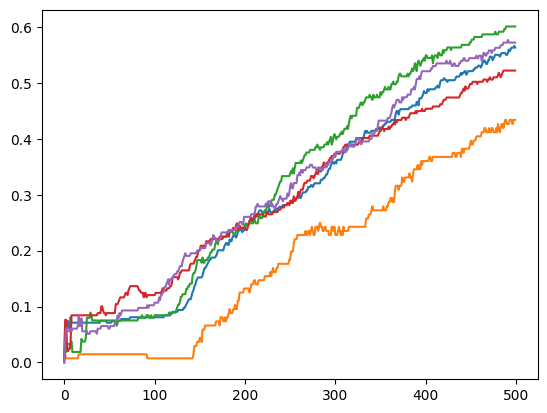

In [19]:
plt.plot(train_accuracies)

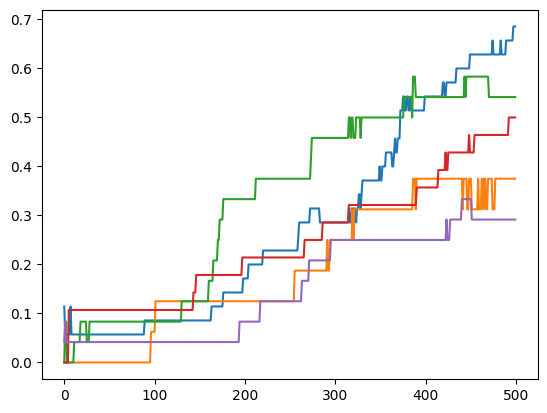

In [20]:
plt.plot(test_accuracies)

In [21]:
print(losses)

[[4.262498378753662, 4.315073251724243, 4.1767518520355225, 4.140238523483276, 4.132472276687622], [4.11150582631429, 4.12672758102417, 4.130622625350952, 4.113129377365112, 4.112071752548218], [4.08566157023112, 4.104461669921875, 4.112617015838623, 4.097030401229858, 4.088764429092407], [4.059657096862793, 4.090248346328735, 4.094720840454102, 4.075960874557495, 4.061825513839722], [4.025110562642415, 4.074168920516968, 4.06809663772583, 4.049756765365601, 4.026884317398071], [3.9841219584147134, 4.055764675140381, 4.037828683853149, 4.016879081726074, 3.986381769180298], [3.9442811012268066, 4.038125038146973, 4.005958080291748, 3.982688307762146, 3.943608283996582], [3.906094471613566, 4.023500204086304, 3.973572850227356, 3.950536012649536, 3.901589870452881], [3.872302293777466, 4.014508485794067, 3.9417295455932617, 3.9183332920074463, 3.8604824542999268], [3.842721700668335, 4.00911557674408, 3.9123376607894897, 3.888614058494568, 3.823676347732544], [3.818730115890503, 4.00547

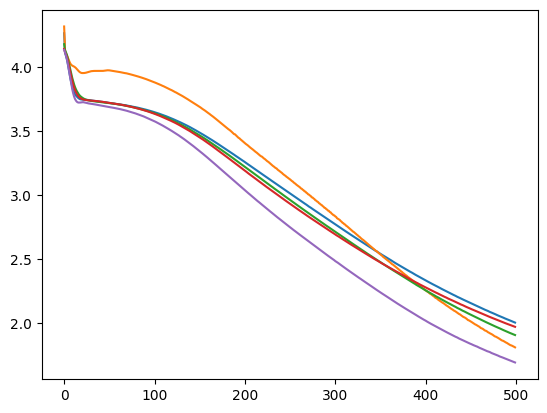

In [22]:
plt.plot(losses)

In [23]:

nodes = []
ypred_test = []
ylabels_test = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  309
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  136
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  213
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  249
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  215
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [24]:
losses = []
train_accuracies = []
test_accuracies = []
test_losses = []
f1_scores = []

start_time = time.time()
for i in tqdm(range(epoch_total)):
    epoch_losses = []
    epoch_acc = []
    for node in nodes:
        tarin_acc, loss = node.train_epoch()
        epoch_acc.append(tarin_acc)
        epoch_losses.append(loss)
    train_accuracies.append(epoch_acc)
    losses.append(epoch_losses)


    
    epoch_test_accuracies = []
    epoch_test_losses = []
    epoch_f1_scores = []
    for i, node in enumerate(nodes):

        node.testing()
        epoch_test_accuracies.append(node.test_accuracy)
        epoch_test_losses.append(node.test_loss)
        epoch_f1_scores.append(node.f1_score)
            
    test_accuracies.append(epoch_test_accuracies)
    test_losses.append(epoch_test_losses)
    f1_scores.append(epoch_f1_scores)
    
    av_state = {}
    
    
    
    states = [i.network.state_dict() for i in nodes]
    av_state = {}
    for key in states[0]:
        av_state[key] = sum([s[key] for s in states])/num_nodes
    for node in nodes:
        node.network.load_state_dict(av_state)

time_FL = time.time() - start_time

print("Time taken by FL without SMPC", time_FL)
    

100%|██████████| 500/500 [00:20<00:00, 24.40it/s]

Time taken by FL without SMPC 20.49622917175293


In [25]:
f1_y_test = []
f1_y_label = []
for node in nodes:
    y_test, y_label = node.f1pred()
    f1_y_test.append(y_test)
    f1_y_label.append(y_label)
f1_y_test = torch.cat(f1_y_test)
f1_y_label = torch.cat(f1_y_label)
# f1_y_test
#f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")

In [26]:
f1_global = f1_score(f1_y_label.cpu(), f1_y_test.cpu(), average="weighted")
print(f1_global)

0.48064800723438983


In [27]:
#print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [28]:
global_mean = 0.0
global_std = 0.0
eqn1= 0.0 
eqn2 = 0.0
eqn3 = 0.0
for node in nodes:
    eqn1 += node.mean * node.dataset_size
    eqn2 += node.dataset_size 
    eqn3 += node.std


global_mean = eqn1/eqn2
global_std = eqn3/eqn2
print("Global Mean", global_mean.shape)
print("Global std ", global_std.shape)
#plt.imshow(global_mean.squeeze())
#plt.imshow(global_std.squeeze())

Global Mean torch.Size([1, 28, 28])
Global std  torch.Size([1, 28, 28])


In [29]:
result2["train_accuracies"] = train_accuracies
result2["train_losses"] = losses
result2["test_accuracies"] = test_accuracies
result2["test_losses"] = test_losses
result2["f1_scores"] = f1_scores
result2["ypred_test"] = f1_y_test
result2["ylabels_test"] = f1_y_label
result2["time_taken"] = time_FL
result2["f1_global"] = f1_global


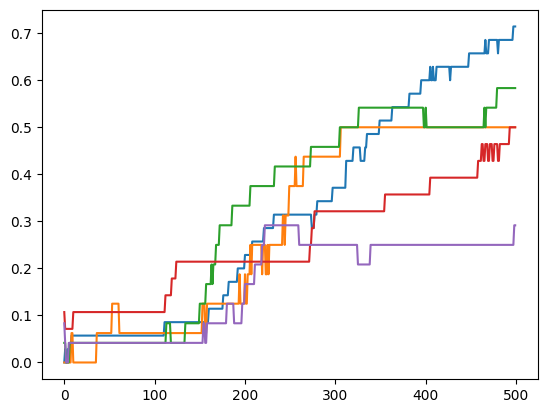

In [30]:
plt.plot(result2["test_accuracies"])

In [31]:
my_pickle_results["vanilla"] = result2
#print(my_pickle_results)
# pickle.dumps(my_pickle_results)
print(my_pickle_results["vanilla"]["time_taken"])

20.49622917175293


In [32]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
#print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

In [34]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-14 17:02:23
